# Transfer Learning

With certain data types it is possible to use the weights learned in one task to be **transferred** to another task. For example in a task that is used to detect Animals and Vehicles in images (as done in CIFAR10) could be reused to classify dogs and cats. 

Transfer Learning is heavily used in Image recognition and Natural Language Processing (NLP) related tasks.

This tutorial is based on https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html.
![alt-text](./images/doge.jpg)

In [1]:
!pip install tqdm
# !conda install -y Pillow
!pip install Pillow

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
from os.path import isfile, isdir, getsize
from os import mkdir, makedirs, remove, listdir
from tqdm import tqdm

import zipfile
import tarfile
import pickle

from keras.models import Sequential, Model
from keras import optimizers
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil

import pickle

%matplotlib inline

/home/iss-user/anaconda3/envs/iss-env-py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Download and extract the doge and cate pictures, as well as some numpy files which will be used later.

In [3]:
catdog_dataset_folder_path = 'catdog'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('catdog.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Doge n Cate Dataset') as pbar:
        urlretrieve(
            'https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip',
            'catdog.zip',
            pbar.hook)

if not isdir(catdog_dataset_folder_path):
    mkdir(catdog_dataset_folder_path)
    with zipfile.ZipFile('catdog.zip') as f:
        f.extractall('./'+catdog_dataset_folder_path)
        # Unfortunately some of the files are corrupt so we need to clean these out:
#         !apt-get install -y jhead > /dev/null 2>&1
        !jhead -de catdog/PetImages/Cat/*.jpg > /dev/null 2>&1 
        !jhead -de catdog/PetImages/Dog/*.jpg > /dev/null 2>&1

# Download numpy files which will be used in transfer learning section
if not isfile('bottleneck_features_train.npy'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Bottleneck features') as pbar:
        urlretrieve(
                'https://www.dropbox.com/s/a38gpvdcryw0kfc/bottleneck.zip?dl=1',
                'bottleneck.zip',
                pbar.hook)

    with zipfile.ZipFile('bottleneck.zip') as f:
        f.extractall('./')
        
    files = listdir('bottleneck 2/')
    
    for f in files:
        shutil.move('bottleneck 2/'+f,'./')
    shutil.rmtree('bottleneck 2/')
    remove('bottleneck.zip')

In [4]:
files = glob.glob(catdog_dataset_folder_path+'/PetImages/**/*.jpg')
labels = np.array([0]*12500+[1]*12500)

size = np.zeros(len(files))
for i,f in enumerate(files):
    size[i] = getsize(f)
    
idx = np.where(size==0)[0]
for i in idx[::-1]:
    del files[i]
    labels = np.delete(labels, i)

In keras we are required to place the training images in a certain folder, with the subfolders structured so that each subfolder contains the class. We will structure the validation folder in the same way:
```
data/
    train/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
    validation/
        dogs/
            dog001.jpg
            dog002.jpg
            ...
        cats/
            cat001.jpg
            cat002.jpg
            ...
```            

From the dataset we randomly choose 20000 images and moves them to training and the rest to testing folders. 

In [5]:
np.random.permutation(5)

array([3, 4, 1, 2, 0])

In [6]:
len_data = len(files)
train_examples = 20000
test_examples = len_data - train_examples

# randomly choose 20000 as training and testing cases
permutation = np.random.permutation(len_data)
train_set = [files[i] for i in permutation[:train_examples]]
test_set = [files[i] for i in permutation[-test_examples:]]
train_labels = labels[permutation[:train_examples]]
test_labels = labels[permutation[-test_examples:]]

train_folder = catdog_dataset_folder_path+'/train'
test_folder = catdog_dataset_folder_path+'/test'

if isdir(train_folder): #if directory already exists
    shutil.rmtree(train_folder)    
if isdir(test_folder): #if directory already exists
    shutil.rmtree(test_folder)    
makedirs(train_folder+'/cat/')
makedirs(train_folder+'/dog/')
makedirs(test_folder+'/cat/')
makedirs(test_folder+'/dog/')

for f,i in zip(train_set, train_labels):
    if i==0:
        shutil.copy2(f, train_folder+'/cat/')
    else:
        shutil.copy2(f, train_folder+'/dog/')
        
for f,i in zip(test_set, test_labels):
    if i==0:
        shutil.copy2(f, test_folder+'/cat/')
    else:
        shutil.copy2(f, test_folder+'/dog/')  

View some sample images:

Found 20000 images belonging to 2 classes.


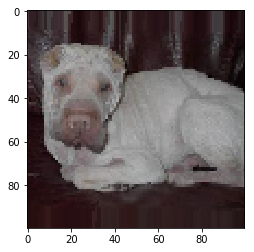

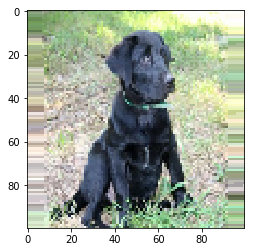

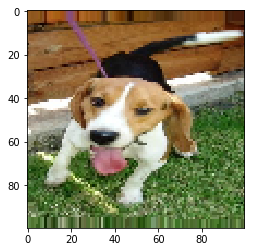

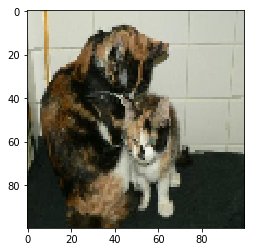

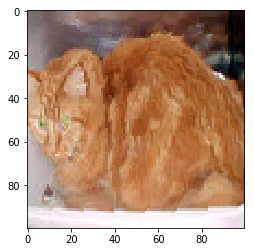

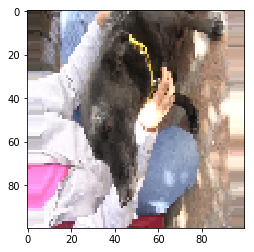

In [7]:
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=5,
        zoom_range=0.2,
        horizontal_flip=True)

img_height = img_width = 100
channels = 3
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=1,
    class_mode=None)

i = 0
img_list = []
for batch in train_generator: #.flow(x, batch_size=1)
    img_list.append(batch)
    i += 1
    if i > 5:
        break
        

for img in img_list:
    plt.imshow(np.squeeze(img))
    plt.show()        

## Basic logistic multiclass classification:

Always, ALWAYS compare to the most basic possible ML/ statistics algorithm. In this case logistic regression.

In [8]:
batch_size = 1000
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.


In [9]:
x_train, y_train = next(train_generator)
x_test, y_test = next(train_generator)

In [10]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train.reshape(batch_size,-1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [11]:
y_pred = logistic.predict(x_test.reshape(len(x_test), -1))
y_pred[:10]

array([0., 0., 1., 0., 1., 0., 1., 1., 0., 1.], dtype=float32)

Predicting the probabilities for the first 3 images:

In [12]:
logistic.predict_proba(x_test[:3].reshape(3,-1))

array([[0.98321292, 0.01678708],
       [0.85034174, 0.14965826],
       [0.39976286, 0.60023714]])

Accuracy of the predictions:

In [13]:
np.count_nonzero(y_pred == y_test)/len(y_test)

0.562

## Convolution Neural Networks (CNN)

In [14]:
model = Sequential()

model.add(Conv2D(8, kernel_size=(3,3), padding='same', input_shape = (img_width,img_height,channels)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(3, 3)))

model.add(Conv2D(16, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 8)       224       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 8)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 16)        1168      
_________________________________________________________________
batch_normalization_1 (Batch (None, 33, 33, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 16)        0         
__________

In [16]:
batch_size = 128
train_generator = datagen.flow_from_directory(
    train_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')
model.fit_generator(train_generator, train_examples//batch_size, epochs=2)

Found 20000 images belonging to 2 classes.
Epoch 1/2
156/156 [==============================] - 441s 3s/step - loss: 0.6660 - acc: 0.6290
Epoch 2/2
156/156 [==============================] - 275s 2s/step - loss: 0.5712 - acc: 0.7021


In [17]:
batch_size = 1
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=False)
y_pred = model.predict_generator(test_generator, test_examples//batch_size, workers=4)
# model.predict_classes(test_x)
# np.count_nonzero(y_pred == test_y)/len(test_y)

Found 4998 images belonging to 2 classes.


In [18]:
correct = 0
for i, f in enumerate(test_generator.filenames):
    if f.startswith('cat') and y_pred[i]<0.5:
        correct +=1
    if f.startswith('dog') and y_pred[i]>=0.5:
        correct +=1

print('Correct predictions: '+str(correct/len(test_generator.filenames)))        

Correct predictions: 0.4921968787515006


In [19]:
batch_size = 6
test_generator = datagen.flow_from_directory(
    test_folder,
    color_mode = "rgb",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle=True)
x_test, y_test = next(test_generator)

p = model.predict(x_test)
p = np.hstack([y_pred, 1-y_pred])
label_dict = {0: 'cat', 1: 'dog'}

Found 4998 images belonging to 2 classes.


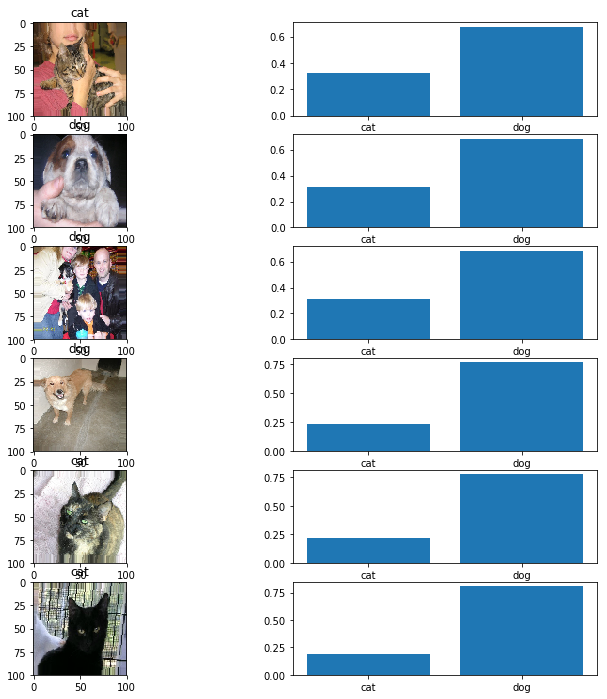

In [20]:
plt.figure(figsize=(12,12))

for i in range(batch_size):
    plt.subplot(batch_size,2,2*i+1)
    plt.imshow(x_test[i])
    plt.title(label_dict[y_test[i]])
    
    plt.subplot(batch_size,2,2*i+2)
    plt.bar(range(2),p[i])
    plt.xticks(range(2), ['cat', 'dog'])
#     plt.show()

plt.show()

In [21]:
p

array([[0.32600227, 0.67399776],
       [0.31548464, 0.68451536],
       [0.31348893, 0.68651104],
       ...,
       [0.29492265, 0.70507735],
       [0.31684756, 0.68315244],
       [0.26339078, 0.7366092 ]], dtype=float32)

## Transfer Learning - Part 1

In [22]:
from keras import applications

datagen = ImageDataGenerator(rescale=1.0/255)
model = applications.VGG16(include_top=False, input_shape=(img_width, img_height, channels))

In [23]:
model = applications.VGG16(include_top=False, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

**Do not _uncomment_ and run the following two blocks unless absolutely necessary**. It takes almost one hour to run. It took me a while to understand why in the Keras blog they had saved the parameters. It isn't necassary for you to save it. However, if you do come back to the tutorial you probably dont want to run this section again. It is slow mainly because there's 14 Million parameters to go through for each example. Having a GPU in this instance would help tremendously.

### Note 1
It is however important to notice that I am **not** training in this block. I am predicting using a truncated VGG16 net. See how I set the `include_top=False` parameter above. VGG16 was originally trained on the CIFAR10 dataset so that it would predict 10 classes. Now that we are truncating it and only using all but the top few layers (lyer closes to the prediction), it outputs a (3,3,512) image in our case.

In [24]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

In [25]:
bottleneck_features_train.shape

(19872, 3, 3, 512)

In [26]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
# bottleneck_features_train = model.predict_generator(generator, train_examples//batch_size, verbose=1, workers=4)
# pickle.dump(bottleneck_features_train, open('bottleneck_features_train.npy', 'wb'))
# bottleneck_features_train.shape

Found 20000 images belonging to 2 classes.


In [27]:
batch_size = 128
valid_generator = datagen.flow_from_directory(
    test_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)
# bottleneck_features_valid = model.predict_generator(generator, test_examples//batch_size, verbose=1, workers=4)
# with open('bottleneck_features_valid.npy', 'wb') as f:
#     pickle.dump(bottleneck_features_valid, f)
# bottleneck_features_valid.shape

Found 4998 images belonging to 2 classes.


In [28]:
with open('bottleneck_features_train.npy','rb') as f:
    bottleneck_features_train = pickle.load(f)

model = Sequential()
model.add(Flatten(input_shape=bottleneck_features_train.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 1,180,161
Trainable params: 1,180,161
Non-trainable params: 0
_________________________________________________________________


In [29]:
batch_size = 128
generator = datagen.flow_from_directory(
    train_folder,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

labels = np.array([0 if f.startswith('cat') else 1 for f in generator.filenames])[:len(bottleneck_features_train)]
model.fit(bottleneck_features_train, labels, epochs=15, batch_size=batch_size)

Found 20000 images belonging to 2 classes.
Epoch 1/15
19872/19872 [==============================] - 12s 579us/step - loss: 0.5254 - acc: 0.7787
Epoch 2/15
19872/19872 [==============================] - 7s 377us/step - loss: 0.3686 - acc: 0.8339
Epoch 3/15
19872/19872 [==============================] - 8s 427us/step - loss: 0.3545 - acc: 0.8459
Epoch 4/15
19872/19872 [==============================] - 16s 781us/step - loss: 0.3622 - acc: 0.8389
Epoch 5/15
19872/19872 [==============================] - 16s 814us/step - loss: 0.3705 - acc: 0.8428
Epoch 6/15
19872/19872 [==============================] - 17s 857us/step - loss: 0.3998 - acc: 0.8347
Epoch 7/15
19872/19872 [==============================] - 16s 797us/step - loss: 0.4256 - acc: 0.8364
Epoch 8/15
19872/19872 [==============================] - 17s 852us/step - loss: 0.4664 - acc: 0.8321
Epoch 9/15
19872/19872 [==============================] - 17s 849us/step - loss: 0.5084 - acc: 0.8281
Epoch 10/15
19872/19872 [================

In [30]:
with open('bottleneck_features_valid.npy','rb') as f:
    bottleneck_features_valid = pickle.load(f)
valid_labels = np.array([0 if f.startswith('cat') else 1 for f in valid_generator.filenames])[:len(bottleneck_features_valid)]
y_valid_pred = model.predict_classes(bottleneck_features_valid)
accuracy = np.count_nonzero(valid_labels == y_valid_pred.ravel())/len(valid_labels)

print('\nThe accuracy is: '+str(accuracy))


The accuracy is: 0.9032854209445585


## Transfer Learning - Part 2

We can refine the model further by adjusting the last convolutional layer.

Note that vgg16 is of type `Model` and not `Sequential`. Hence we cannot `add` the top layer as suggested in the keras blog.

### Note 2
We are setting the trainable weights to be everything but the last convolutional layer and the fully connected (dense) layers. Take note of the number of trainable parameters in the summary below.

In [31]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, channels))
combinedModel = Model(inputs= vgg16.input, outputs= model(vgg16.output))

for layer in combinedModel.layers[:-3]:
    layer.trainable = False

In [32]:
combinedModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

You can try to use the `adagrad` optmizer if you wish but you'll soon see that all the progress that was made in `model` will be undone. It will infact overwrite the weights in `model` and you would have to rerun the `model` training from the `bottleneck_features` section.

Why? It's so that the updates are small and does not destablise the weights that were previously learnt.

In [33]:
model.save_weights('fc_model.h5')

In [34]:
combinedModel.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4, decay=0.9), # optimizers.SGD(lr=1e-4, momentum=0.9)
              metrics=['accuracy'])

In [35]:
combinedModel.compile(loss='binary_crossentropy',
              optimizer = optimizers.RMSprop(lr=1e-4, decay=0.9), # optimizers.SGD(lr=1e-4, momentum=0.9)
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [ ]:
# fine-tune the model
combinedModel.fit_generator(
    train_generator,
    steps_per_epoch=train_examples//batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=test_examples//batch_size) # len(valid_generator.filenames)

Epoch 1/5
156/156 [==============================] - 6359s 41s/step - loss: 0.4418 - acc: 0.8458 - val_loss: 0.2465 - val_acc: 0.9028
Epoch 2/5
156/156 [==============================] - 6130s 39s/step - loss: 0.3907 - acc: 0.8468 - val_loss: 0.2421 - val_acc: 0.9046
Epoch 3/5
156/156 [==============================] - 5843s 37s/step - loss: 0.3898 - acc: 0.8477 - val_loss: 0.2401 - val_acc: 0.9042
Epoch 4/5
155/156 [============================>.] - ETA: 29s - loss: 0.3685 - acc: 0.8520

## Predictions:

In [ ]:
from PIL import Image

img = Image.open('images/doge.jpg')
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255
plt.imshow(img)
plt.show()
p = combinedModel.predict(np.array([img]))
print('The probability that this is a dog is: ' +str(p[0][0]))

In [ ]:
img = Image.open('images/grumpy_cat.jpeg')
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255
plt.imshow(img)
plt.show()
p = combinedModel.predict(np.array([img]))
print('The probability that this is a dog is: ' +str(p[0][0]))

In [ ]:
img = Image.open('images/cat.jpeg')
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255
plt.imshow(img)
plt.show()
p = combinedModel.predict(np.array([img]))
print('The probability that this is a dog is: ' +str(p[0][0]))

Guess it doesn't do so well when there is random clutter:

In [ ]:
img = Image.open('images/grumpy2.jpeg')
img = np.asarray(img.resize((img_height, img_width), Image.ANTIALIAS))/255
plt.imshow(img)
plt.show()
p = combinedModel.predict(np.array([img]))
print('The probability that this is a dog is: ' +str(p[0][0]))

---